In [ ]:
# default_exp fitting

# Comparing InstanceCMR and PrototypeCMR Using the Murdock (1962) Dataset
The main purposes of performing comparisons using the Murdock (1962) dataset is to examine whether both models (here, CMR and InstanceCMR) can adequately account for performance across trial list lengths with a common parameter configuration. Let's review the results here.

In [ ]:
from compmemlearn.fitting import cmr_murd_objective_function, icmr_murd_objective_function, apply_and_concatenate
from compmemlearn.models import Classic_CMR, Instance_CMR
from compmemlearn.datasets import prepare_murdock1962_data

murd_trials0, murd_events0, murd_length0 = prepare_murdock1962_data('../../data/MurdData_clean.mat', 0)
murd_trials1, murd_events1, murd_length1 = prepare_murdock1962_data('../../data/MurdData_clean.mat', 1)
murd_trials2, murd_events2, murd_length2 = prepare_murdock1962_data('../../data/MurdData_clean.mat', 2)
murd_events0.head()

,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,5.0,True,True,0,False
1,1,1,2,2,7.0,True,True,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False


## Across-Subject Fits

### PrototypeCMR Fitting

In [ ]:
from scipy.optimize import differential_evolution
from numba.typed import List
import numpy as np

free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',]

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10)
]


# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = cmr_murd_objective_function(
    List([murd_trials0, murd_trials1, murd_trials2]), 
    {'item_counts': List([murd_length0,murd_length1, murd_length2]), 'sampling_rule': 0, 'familiarity_scale': 0}, free_parameters)

cmr_result = differential_evolution(cost_function, bounds, disp=False)
print(cmr_result)


Now we compute the SPC, CRP, and PFR stats associated with these model fits, contrasted against the actual data. We'll have to compute separate stats for each list length.

In [ ]:
from compmemlearn.datasets import simulate_data
import pandas as pd
from psifr import fr

model0 = Classic_CMR(
    **{**{'item_count': murd_length0, 'presentation_count': murd_length0, 'sampling_rule': 0},
    **{free_parameters[i]:cmr_result.x[i] for i in range(len(cmr_result.x))}})

model1 = Classic_CMR(
    **{**{'item_count': murd_length1, 'presentation_count': murd_length1, 'sampling_rule': 0},
    **{free_parameters[i]:cmr_result.x[i] for i in range(len(cmr_result.x))}})

model2 = Classic_CMR(
    **{**{'item_count': murd_length2, 'presentation_count': murd_length2, 'sampling_rule': 0},
    **{free_parameters[i]:cmr_result.x[i] for i in range(len(cmr_result.x))}})

sim_df0 = simulate_data(model0, 1000)
sim_df1 = simulate_data(model1, 1000)
sim_df2 = simulate_data(model2, 1000)
true_df0 = murd_events0.copy()
true_df1 = murd_events1.copy()
true_df2 = murd_events2.copy()

cmr_spc0 = apply_and_concatenate(fr.spc, sim_df0, true_df0, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp0 = apply_and_concatenate(fr.lag_crp, sim_df0, true_df0, 'source', ['PrototypeCMR', 'data'])
cmr_pfr0 = apply_and_concatenate(fr.pnr, sim_df0, true_df0, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr0 = cmr_pfr0.query('output <= 1')

cmr_spc1 = apply_and_concatenate(fr.spc, sim_df1, true_df1, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp1 = apply_and_concatenate(fr.lag_crp, sim_df1, true_df1, 'source', ['PrototypeCMR', 'data'])
cmr_pfr1 = apply_and_concatenate(fr.pnr, sim_df1, true_df1, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr1 = cmr_pfr1.query('output <= 1')

cmr_spc2 = apply_and_concatenate(fr.spc, sim_df2, true_df2, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_lag_crp2 = apply_and_concatenate(fr.lag_crp, sim_df2, true_df2, 'source', ['PrototypeCMR', 'data'])
cmr_pfr2 = apply_and_concatenate(fr.pnr, sim_df2, true_df2, contrast_name='source', labels=['PrototypeCMR', 'data'])
cmr_pfr2 = cmr_pfr2.query('output <= 1')

### InstanceCMR Fitting

In [ ]:
free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
#    'choice_sensitivity',
    'context_sensitivity',
#    'feature_sensitivity'
]

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
#    (lb, 10),
#    (lb, 10)
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
cost_function = icmr_murd_objective_function(
    List([murd_trials2]), #List([murd_trials0, murd_trials1, murd_trials2]), 
    {'item_counts': List([murd_length2]), 'choice_sensitivity': 1, # List([murd_length0,murd_length1, murd_length2]),
    'feature_sensitivity': 1}, free_parameters)

icmr_result = differential_evolution(cost_function, bounds, disp=True)
print(icmr_result)
print(icmr_result.fun)

differential_evolution step 1: f(x)= 72522.9
differential_evolution step 2: f(x)= 44221.2
differential_evolution step 3: f(x)= 37939.4
differential_evolution step 4: f(x)= 37939.4
differential_evolution step 5: f(x)= 37809.9
differential_evolution step 6: f(x)= 37809.9
differential_evolution step 7: f(x)= 37759.3
differential_evolution step 8: f(x)= 37744.8
differential_evolution step 9: f(x)= 37393.6
differential_evolution step 10: f(x)= 37393.6
differential_evolution step 11: f(x)= 37393.6
differential_evolution step 12: f(x)= 36665.9
differential_evolution step 13: f(x)= 36070.6
differential_evolution step 14: f(x)= 36070.6
differential_evolution step 15: f(x)= 36070.6
differential_evolution step 16: f(x)= 36070.6
differential_evolution step 17: f(x)= 36070.6
differential_evolution step 18: f(x)= 35240.2
differential_evolution step 19: f(x)= 31984.8
differential_evolution step 20: f(x)= 31984.8
differential_evolution step 21: f(x)= 31984.8
differential_evolution step 22: f(x)= 31984

In [ ]:
model0 = Instance_CMR(
    **{**{'item_count': murd_length0, 'presentation_count': murd_length0, 'choice_sensitivity': 1, 'feature_sensitivity': 1}, 
    **{free_parameters[i]:icmr_result.x[i] for i in range(len(icmr_result.x))}})

model1 = Instance_CMR(
    **{**{'item_count': murd_length1, 'presentation_count': murd_length1, 'choice_sensitivity': 1, 'feature_sensitivity': 1}, 
    **{free_parameters[i]:icmr_result.x[i] for i in range(len(icmr_result.x))}})

model2 = Instance_CMR(
    **{**{'item_count': murd_length2, 'presentation_count': murd_length2, 'choice_sensitivity': 1, 'feature_sensitivity': 1}, 
    **{free_parameters[i]:icmr_result.x[i] for i in range(len(icmr_result.x))}})

sim_df0 = simulate_data(model0, 1000)
sim_df1 = simulate_data(model1, 1000)
sim_df2 = simulate_data(model2, 1000)
true_df0 = murd_events0.copy()
true_df1 = murd_events1.copy()
true_df2 = murd_events2.copy()

icmr_spc0 = apply_and_concatenate(fr.spc, sim_df0, true_df0, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_lag_crp0 = apply_and_concatenate(fr.lag_crp, sim_df0, true_df0, 'source', ['InstanceCMR', 'data'])
icmr_pfr0 = apply_and_concatenate(fr.pnr, sim_df0, true_df0, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_pfr0 = icmr_pfr0.query('output <= 1')

icmr_spc1 = apply_and_concatenate(fr.spc, sim_df1, true_df1, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_lag_crp1 = apply_and_concatenate(fr.lag_crp, sim_df1, true_df1, 'source', ['InstanceCMR', 'data'])
icmr_pfr1 = apply_and_concatenate(fr.pnr, sim_df1, true_df1, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_pfr1 = icmr_pfr1.query('output <= 1')

icmr_spc2 = apply_and_concatenate(fr.spc, sim_df2, true_df2, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_lag_crp2 = apply_and_concatenate(fr.lag_crp, sim_df2, true_df2, 'source', ['InstanceCMR', 'data'])
icmr_pfr2 = apply_and_concatenate(fr.pnr, sim_df2, true_df2, contrast_name='source', labels=['InstanceCMR', 'data'])
icmr_pfr2 = icmr_pfr2.query('output <= 1')

In [ ]:
icmr_spc = pd.concat([icmr_spc0, icmr_spc1, icmr_spc2], 
    keys=[str(murd_length0), str(murd_length1), str(murd_length2)], 
    names=['List Length']).reset_index()
icmr_spc.drop(['level_1'], axis=1, inplace=True)

icmr_spc.

,List Length,source,subject,input,recall
0,20,InstanceCMR,0,1,0.0
1,20,InstanceCMR,0,2,0.0
2,20,InstanceCMR,0,3,0.0
3,20,InstanceCMR,0,4,0.0
4,20,InstanceCMR,0,5,0.0


### Visualization
This is a bit tricky. We want to plot the PFR, CRP, and SPC for each list length and for each model. Could maybe use different colors for list lengths but vary line styles to distinguish the data from the model? Let's try just a serial position curve first.

#### InstanceCMR

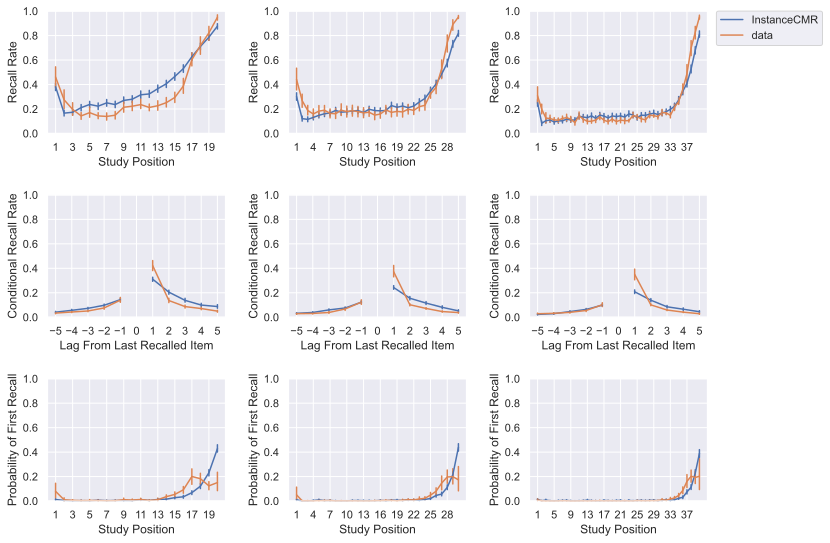

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']
sns.set(style='darkgrid')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12/1.5), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0, 0], data=icmr_spc0, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 0].set_xticks(np.arange(1, murd_length0+1, 2))
axes[0, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[0, 1], data=icmr_spc1, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 1].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 1].set_xticks(np.arange(1, murd_length1+1, 3))
axes[0, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[0, 2], data=icmr_spc2, x='input', y='recall', err_style='bars', hue='source', legend=True)
axes[0, 2].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 2].set_xticks(np.arange(1, murd_length2+1, 4))
axes[0, 2].set_ylim((0, 1))

# lag CRP
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1, 0], data=icmr_lag_crp0.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 0], data=icmr_lag_crp0.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 0].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 0].set_xticks(np.arange(-5, 6, 1))
axes[1, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 1], data=icmr_lag_crp1.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 1], data=icmr_lag_crp1.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 1].set(xlabel="Lag From Last Recalled Item", ylabel='Conditional Recall Rate')
axes[1, 1].set_xticks(np.arange(-5, 6, 1))
axes[1, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 2], data=icmr_lag_crp2.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 2], data=icmr_lag_crp2.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 2].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 2].set_xticks(np.arange(-5, 6, 1))
axes[1, 2].set_ylim((0, 1))

# pfr
sns.lineplot(data=icmr_pfr0, x='input', y='prob', err_style='bars', ax=axes[2, 0], hue='source', legend=False)
axes[2, 0].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 0].set_xticks(np.arange(1, murd_length0+1, 2))
axes[2, 0].set_ylim((0, 1))

sns.lineplot(data=icmr_pfr1, x='input', y='prob', err_style='bars', ax=axes[2, 1], hue='source', legend=False)
axes[2, 1].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 1].set_xticks(np.arange(1, murd_length1+1, 3))
axes[2, 1].set_ylim((0, 1))

sns.lineplot(data=icmr_pfr2, x='input', y='prob', err_style='bars', ax=axes[2, 2], hue='source', legend=False)
axes[2, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 2].set_xticks(np.arange(1, murd_length2+1, 4))
axes[2, 2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=2)
plt.savefig('icmr_summary_murdock1962.pdf', bbox_inches="tight")

#### CMR

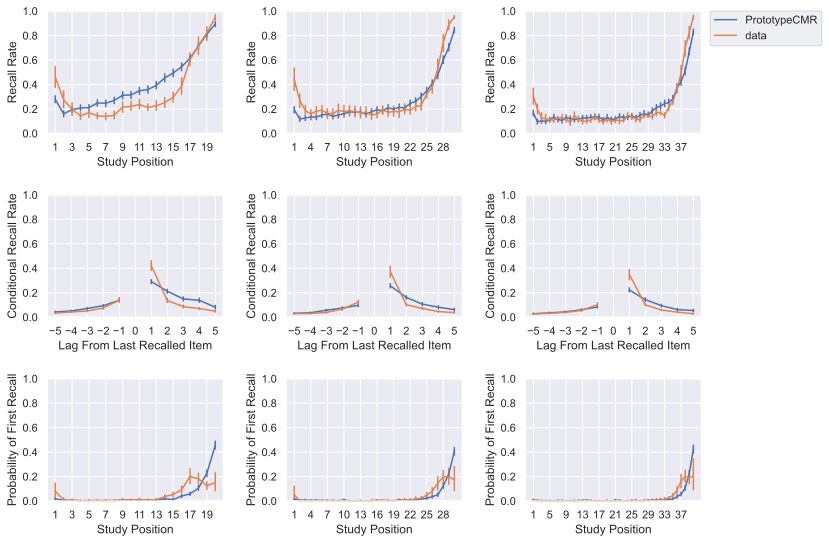

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12/1.5), sharey=False)

# serial position curve
sns.lineplot(ax=axes[0, 0], data=cmr_spc0, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 0].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 0].set_xticks(np.arange(1, murd_length0+1, 2))
axes[0, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[0, 1], data=cmr_spc1, x='input', y='recall', err_style='bars', hue='source', legend=False)
axes[0, 1].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 1].set_xticks(np.arange(1, murd_length1+1, 3))
axes[0, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[0, 2], data=cmr_spc2, x='input', y='recall', err_style='bars', hue='source', legend=True)
axes[0, 2].set(xlabel='Study Position', ylabel='Recall Rate')
axes[0, 2].set_xticks(np.arange(1, murd_length2+1, 4))
axes[0, 2].set_ylim((0, 1))

# lag CRP
max_lag = 5
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

sns.lineplot(ax=axes[1, 0], data=cmr_lag_crp0.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 0], data=cmr_lag_crp0.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 0].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 0].set_xticks(np.arange(-5, 6, 1))
axes[1, 0].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp1.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 1], data=cmr_lag_crp1.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 1].set(xlabel="Lag From Last Recalled Item", ylabel='Conditional Recall Rate')
axes[1, 1].set_xticks(np.arange(-5, 6, 1))
axes[1, 1].set_ylim((0, 1))

sns.lineplot(ax=axes[1, 2], data=cmr_lag_crp2.query(filt_neg), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
sns.lineplot(ax=axes[1, 2], data=cmr_lag_crp2.query(filt_pos), x='lag', y='prob', 
             err_style='bars', hue='source', legend=False)
axes[1, 2].set(xlabel='Lag From Last Recalled Item', ylabel='Conditional Recall Rate')
axes[1, 2].set_xticks(np.arange(-5, 6, 1))
axes[1, 2].set_ylim((0, 1))

# pfr
sns.lineplot(data=cmr_pfr0, x='input', y='prob', err_style='bars', ax=axes[2, 0], hue='source', legend=False)
axes[2, 0].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 0].set_xticks(np.arange(1, murd_length0+1, 2))
axes[2, 0].set_ylim((0, 1))

sns.lineplot(data=cmr_pfr1, x='input', y='prob', err_style='bars', ax=axes[2, 1], hue='source', legend=False)
axes[2, 1].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 1].set_xticks(np.arange(1, murd_length1+1, 3))
axes[2, 1].set_ylim((0, 1))

sns.lineplot(data=cmr_pfr2, x='input', y='prob', err_style='bars', ax=axes[2, 2], hue='source', legend=False)
axes[2, 2].set(xlabel='Study Position', ylabel='Probability of First Recall')
axes[2, 2].set_xticks(np.arange(1, murd_length2+1, 4))
axes[2, 2].set_ylim((0, 1))

# set legend of axis 2 outside the plot, to the right
axes[0, 2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=2)
plt.savefig('cmr_summary_murdock1962.pdf', bbox_inches="tight")

## Individual-Level Fitting

In [ ]:
free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',]

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10)
]

subject_trial_count = 80 # Each subject gets 80 trials/lists a piece.
individual_cmr_results = []

for subject, start_index in enumerate(range(0, len(murd_trials0), subject_trial_count)):
    print(subject, start_index)

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = cmr_murd_objective_function(
        List([murd_trials0[start_index:start_index+subject_trial_count], murd_trials1[start_index:start_index+subject_trial_count], murd_trials2[start_index:start_index+subject_trial_count]]), 
        {'item_counts': List([murd_length0, murd_length1, murd_length2]), 'sampling_rule': 0, 'familiarity_scale': 0}, free_parameters)

    individual_cmr_results.append(differential_evolution(cost_function, bounds, disp=False))
    print(individual_cmr_results[-1].fun)

0 0
4478.94154569687
1 80
5665.322082495182
2 160
5285.501045716691
3 240
5276.811618120008
4 320
5569.054880606494
5 400
5803.640050905283
6 480
4905.145171753129
7 560
4495.596885112689
8 640
4833.97173682412
9 720
5501.911808071029
10 800
4731.3613512225975
11 880
5318.16843279753
12 960
5989.749492721001
13 1040
6391.323729557362
14 1120
5367.953839482903


In [ ]:
free_parameters = [
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
#    'choice_sensitivity',
    'context_sensitivity',
#    'feature_sensitivity'
]

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
#    (lb, 10),
#    (lb, 10)
]

subject_trial_count = 80 # Each subject gets 20 trials/lists a piece.
individual_icmr_results = []

for subject, start_index in enumerate(range(0, len(murd_trials0), subject_trial_count)):
    print(subject, start_index)

    # cost function to be minimized
    # ours scales inversely with the probability that the data could have been 
    # generated using the specified parameters and our model
    cost_function = icmr_murd_objective_function(
    List([murd_trials0[start_index:start_index+subject_trial_count], 
        murd_trials1[start_index:start_index+subject_trial_count], 
        murd_trials2[start_index:start_index+subject_trial_count]]), 
    {'item_counts': List([murd_length0,murd_length1, murd_length2]), 
    'choice_sensitivity': 1, 'feature_sensitivity': 1}, free_parameters)

    individual_icmr_results.append(differential_evolution(cost_function, bounds, disp=False))
    print(individual_icmr_results[-1].fun)

0 0
4474.131422494598
1 80
5708.929930924609
2 160
5285.338698317857
3 240
5267.719601070343
4 320
5569.217443595756
5 400
5799.541356764831
6 480
4923.32562395256
7 560
4559.050000767352
8 640
4830.433840184683
9 720
5498.349516665581
10 800
4710.297805543553
11 880
5343.464531422168
12 960
5968.853466689654
13 1040
6394.26493848573
14 1120
5415.203891708852


In [ ]:
individual_fits = [result.fun for result in individual_cmr_results] + [result.fun for result in individual_icmr_results]
labels = ['PrototypeCMR'] * len(individual_cmr_results) + ['InstanceCMR'] * len(individual_icmr_results)
individual_df = pd.DataFrame(individual_fits, index=labels, columns=['Fit']).reset_index()
individual_df.columns = ['Model', 'Fit']

In [ ]:
print(pd.DataFrame(group.describe().rename(columns={'Fit':name}).squeeze()
            for name, group in individual_df.groupby('Model')).T.to_markdown())

|       |   InstanceCMR |   PrototypeCMR |
|:------|--------------:|---------------:|
| count |        15     |         15     |
| mean  |      5316.54  |       5307.63  |
| std   |       542.933 |        547.036 |
| min   |      4474.13  |       4478.94  |
| 25%   |      4876.88  |       4869.56  |
| 50%   |      5343.46  |       5318.17  |
| 75%   |      5639.07  |       5617.19  |
| max   |      6394.26  |       6391.32  |


### Visualization

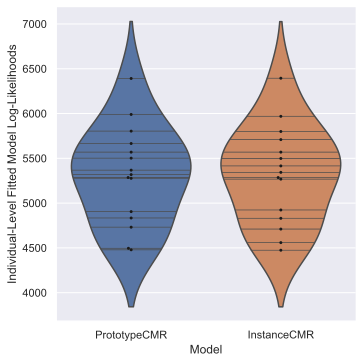

In [ ]:
sns.set(style="darkgrid")

g = sns.catplot(x='Model', y='Fit', data=individual_df, kind='violin', inner='stick')
sns.swarmplot(x="Model", y="Fit", color="k", size=3, data=individual_df, ax=g.ax)
g.ax.set_ylabel('Individual-Level Fitted Model Log-Likelihoods');
plt.savefig('individual_murdock1962.pdf', bbox_inches="tight")

In [ ]:
murd_events0

,subject,list,item,input,output,study,recall,repeat,intrusion
0,1,1,1,1,5.0,True,True,0,False
1,1,1,2,2,7.0,True,True,0,False
2,1,1,3,3,NaN,True,False,0,False
3,1,1,4,4,NaN,True,False,0,False
4,1,1,5,5,NaN,True,False,0,False
...,...,...,...,...,...,...,...,...,...
23995,15,80,16,16,1.0,True,True,0,False
23996,15,80,17,17,NaN,True,False,0,False
23997,15,80,18,18,NaN,True,False,0,False
23998,15,80,19,19,2.0,True,True,0,False
